In [1]:
import warnings
warnings.filterwarnings('ignore')

In [ ]:
!unzip /content/archive.zip

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import os
import math
import shutil
import glob

In [4]:
# count the number of images in the respective classes Brain tumor - 0 , Healthy - 1
ROOT_DIR = "/content/brain_tumor_dataset"
number_of_images = {}
# list dir will give what is present in that particular folder
for dir in os.listdir(ROOT_DIR):
  number_of_images[dir] = len(os.listdir(os.path.join(ROOT_DIR , dir))) # without len it will show every image

number_of_images.items()

dict_items([('yes', 155), ('no', 98)])

# split the data such as
* 70 % for train data
* 15 % for validation
* 15 % for testing


In [5]:
# function to split the data according to our need
def dataFolder(p , split):
  if not os.path.exists("./"+p):
    os.mkdir("./"+p)

    for dir in os.listdir(ROOT_DIR):
      os.makedirs("./"+p+"/"+dir)
      for img in np.random.choice(a = os.listdir(os.path.join(ROOT_DIR, dir)) , 
                                size = (math.floor(split*number_of_images[dir])-2) ,
                                replace=False):
        O = os.path.join(ROOT_DIR,dir,img) # path
        D = os.path.join("./"+p,dir)
        shutil.copy(O,D)
        os.remove(O)
  else:
    print(f"{p} folder already exist ")    

In [6]:
dataFolder("train" , 0.7)

In [7]:
dataFolder("val", 0.15)

In [8]:
dataFolder("test", 0.15)

# Model Build

In [9]:
from keras.layers import Conv2D , MaxPool2D , Dropout , Flatten , Dense , BatchNormalization , GlobalAvgPool2D
from keras.models import Sequential , Model , load_model
from keras.preprocessing.image import ImageDataGenerator
import keras
from keras.applications.mobilenet import MobileNet
from keras.applications.mobilenet import preprocess_input

In [10]:
# CNN Model

#model = Sequential()
#model.add(Conv2D(filters=8, kernel_size=(3, 3), activation='relu', input_shape=(224, 224, 3), padding='same'))

#model.add(Conv2D(filters=16, kernel_size=(3, 3), activation='relu'))
#model.add(MaxPool2D(pool_size=(2, 2)))

#model.add(Conv2D(filters=32, kernel_size=(3, 3), activation='relu'))
#model.add(MaxPool2D(pool_size=(2, 2)))

#model.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu'))
#model.add(MaxPool2D(pool_size=(2, 2)))

#model.add(Dropout(rate=0.25))

#model.add(Flatten())
#model.add(Dense(units=32, activation='relu'))
#model.add(Dropout(rate=0.25))
#model.add(Dense(units=1, activation='sigmoid'))

#model.summary()

base_model = MobileNet(input_shape=(224,224,3) , include_top = False)

In [17]:
for layer  in base_model.layers:
  layer.trainable = False

In [16]:
x = base_model.output
x = Flatten()(x)

# Add Dense layer
x = Dense(units=1, activation='sigmoid')(x)

# Assign the output of new layers to the base_model output
output = x

# Create the new model
model = Model(inputs=base_model.input, outputs=output)

# Print the model summary
model.summary()

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv1 (Conv2D)              (None, 112, 112, 32)      864       
                                                                 
 conv1_bn (BatchNormalizatio  (None, 112, 112, 32)     128       
 n)                                                              
                                                                 
 conv1_relu (ReLU)           (None, 112, 112, 32)      0         
                                                                 
 conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)     288       
                                                                 
 conv_dw_1_bn (BatchNormaliz  (None, 112, 112, 32)     128       
 ation)                                                    

In [18]:
model.compile(optimizer='rmsprop', loss= keras.losses.binary_crossentropy , metrics=['accuracy'])

# Preparing Data using Data Generator


In [19]:
def preprocessingImages1(path):
  """
  input : Path
  output : Pre processed images
  """
  image_data = ImageDataGenerator(zoom_range= 0.2, shear_range= 0.2, preprocessing_function= preprocess_input, horizontal_flip= True)
  image = image_data.flow_from_directory(directory= path , target_size= (224,224), batch_size= 32, class_mode='binary')
  return image

In [20]:
path = "/content/train"
train_data = preprocessingImages1(path)

Found 172 images belonging to 2 classes.


In [21]:
def preprocessingImages2(path):
  """
  input : Path
  output : Pre processed images
  """
  image_data = ImageDataGenerator(preprocessing_function= preprocess_input)
  image = image_data.flow_from_directory(directory= path , target_size= (224,224), batch_size= 32, class_mode='binary')
  return image

In [22]:
path = "/content/test"
test_data = preprocessingImages2(path)

Found 33 images belonging to 2 classes.


In [23]:
path = "/content/val"
val_data = preprocessingImages2(path)

Found 33 images belonging to 2 classes.


In [24]:
# Early stopping and model check point

from keras.callbacks import ModelCheckpoint , EarlyStopping

# Early stopping

es = EarlyStopping(monitor = "val_accuracy" , min_delta = 0.01, patience = 3 , verbose = 1)

# model check point

mc = ModelCheckpoint(monitor = "val_accuracy" , filepath="./bestmodel.h5" , verbose = 1 ,save_best_only= True)

cd  =[es,mc]

#Model Training

In [25]:
hs = model.fit_generator(train_data,
                         steps_per_epoch=len(train_data),
                         epochs=30,
                         validation_data=val_data,
                         validation_steps=len(val_data),
                         callbacks=cd)

Epoch 1/30
6/6 [==============================] - ETA: 0s - loss: 9.5432 - accuracy: 0.5581
Epoch 1: val_accuracy improved from -inf to 0.63636, saving model to ./bestmodel.h5
6/6 [==============================] - 13s 644ms/step - loss: 9.5432 - accuracy: 0.5581 - val_loss: 5.0333 - val_accuracy: 0.6364
Epoch 2/30
6/6 [==============================] - ETA: 0s - loss: 2.6718 - accuracy: 0.7500
Epoch 2: val_accuracy improved from 0.63636 to 0.93939, saving model to ./bestmodel.h5
6/6 [==============================] - 3s 603ms/step - loss: 2.6718 - accuracy: 0.7500 - val_loss: 0.4926 - val_accuracy: 0.9394
Epoch 3/30
6/6 [==============================] - ETA: 0s - loss: 0.3003 - accuracy: 0.9593
Epoch 3: val_accuracy did not improve from 0.93939
6/6 [==============================] - 2s 387ms/step - loss: 0.3003 - accuracy: 0.9593 - val_loss: 0.9464 - val_accuracy: 0.8485
Epoch 4/30
6/6 [==============================] - ETA: 0s - loss: 0.8567 - accuracy: 0.8605
Epoch 4: val_accuracy 

In [26]:
# Model Graphical Interpretation

h = hs.history
h.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

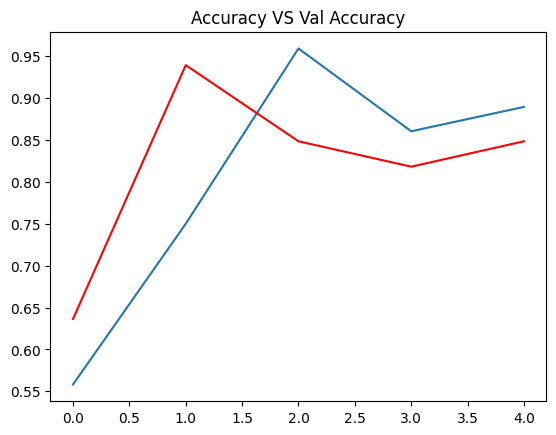

In [27]:
import matplotlib.pyplot as plt

plt.plot(h['accuracy'])
plt.plot(h['val_accuracy'] , c ='red')

plt.title("Accuracy VS Val Accuracy")
plt.show()


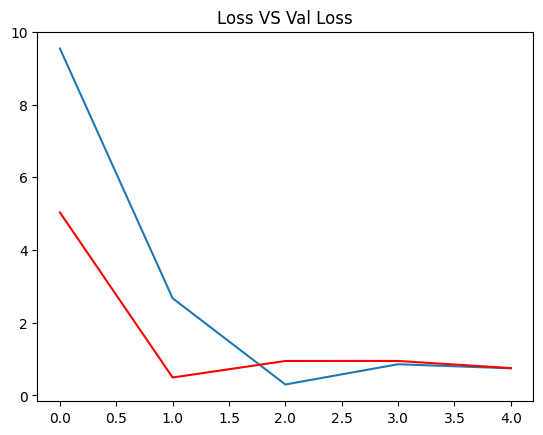

In [28]:
import matplotlib.pyplot as plt

plt.plot(h['loss'])
plt.plot(h['val_loss'] , c ='red')

plt.title("Loss VS Val Loss")
plt.show()

In [29]:
# load the best fit model

model = load_model("/content/bestmodel.h5")

In [30]:
acc = model.evaluate_generator(test_data)[1]
print(f"Model accuracy : {acc*100} % ")

Model accuracy : 87.87878751754761 % 


In [38]:
from tensorflow.keras.preprocessing import image

1/1 [==============================] - 0s 427ms/step
The MRI scan is of brain tumor


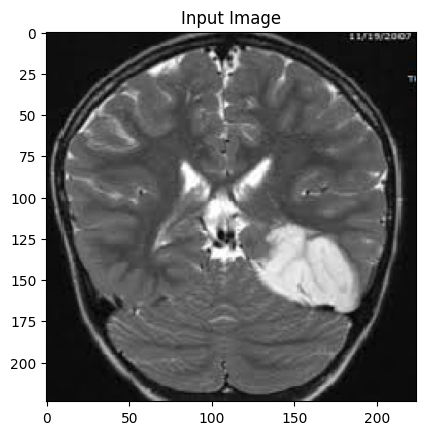

In [39]:
# prediction of the images

path = "/content/brain_tumor_dataset/yes/Y250.jpg"
img = image.load_img(path, target_size=(224,224))

i = image.img_to_array(img)/255
input_arr = np.array([i])
input_arr.shape

pred = np.argmax(model.predict(input_arr))

if pred ==0 :
  print("The MRI scan is of brain tumor")
else:
  print("The MRI scan is of healthy brain")

# Displaying image
plt.imshow(input_arr[0])
plt.title("Input Image")
plt.show()  